In [1]:
%matplotlib widget

In [2]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

In [3]:
env = xt.Environment()
env.call('../fccee_z_lattice.py')
env.call('../002_design_optics/quad_strength_limits.py')
env.call('../002_design_optics/matching_constraints.py')

In [4]:
line = env['cell_uffl']

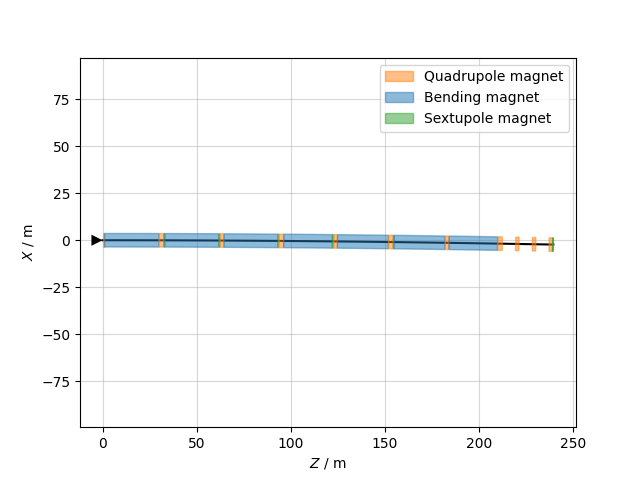

In [5]:
line.survey().plot()

In [6]:
# To ge boundary conditions on the arc side we load the arc cell strengths from previous match
env.vars.load_json('strengths_quads_00_arc_cell.json')
tw_uu = (2 * env['cell_u']).twiss4d()

### Strengths to match

In [7]:
kq_ff_ds = [
    'kqfm0l', 'kqdm0l', 'kqfm1l', 'kqdm2l', 'kqfm3l',
    'kqdm4l', 'kqfm5l', 'kqdm6l', 'kqfm7l', 'kqdm8l',
]

In [8]:
# Initialize quadrupoles with a small strength
for nn in kq_ff_ds:
    if line.vars.vary_default[nn]['limits'][1] > 1e-3: # Focusing quad
        line[nn] = 1e-3
    else: # Defocusing quad
        line[nn] = -1e-3

In [9]:
opt = line.match(
    solve=False,
    method='4d',
    betx=tw_uu.betx[0], bety=tw_uu.bety[0],
    alfx=tw_uu.alfx[0], alfy=tw_uu.alfy[0],
    dx=tw_uu.dx[0], dpx=tw_uu.dpx[0],
    vary=xt.VaryList(kq_ff_ds, step=1e-10),
    targets=[
        xt.TargetSet(at=xt.END,
            betx=env['bx_ff_out'],
            bety=env['by_ff_out'],
            alfx=0, alfy=0, dx=0, dpx=0,
            mux = tw_uu.mux[-1]  * 0.25 + 0.50,
            muy = tw_uu.muy[-1]  * 0.25 + 0.50),
        xt.TargetSet(dx=0, dpx=0, at='qdm6l', weight=1000),
        xt.TargetSet(dx=0, dpx=0, at='qfm5l', weight=1000),
        xt.TargetSet(bety=xt.GreaterThan(350), at='qfm5l'),
        xt.TargetSet(bety=xt.GreaterThan(600), at='qfm7l'),
        xt.TargetSet(bety=xt.LessThan(600), at='qdm6l'),
        xt.TargetSet(betx=xt.LessThan(200), bety=xt.LessThan(200), at='qfm0l'),
        xt.TargetSet(betx=xt.LessThan(200), bety=xt.LessThan(200), at='qfm1l'),
        xt.TargetSet(betx=xt.LessThan(200), bety=xt.LessThan(200), at='qdm2l'),
        xt.TargetSet(betx=xt.LessThan(200), bety=xt.LessThan(200), at='qfm3l'),
        xt.TargetSet(betx=xt.LessThan(200), bety=xt.LessThan(200), at='qdm4l'),
    ],
)

In [10]:
opt.targets['END_mux'].weight = 1000
opt.targets['END_muy'].weight = 1000

In [11]:
opt.reload(0)
opt.clear_log()

In [12]:
opt.run_nelder_mead(1000)
opt.run_nelder_mead(1000)
opt.run_jacobian(100)

                                             
Optimize - start penalty: 4648                              
Matching: model call n. 1456 penalty = 1.5850e+03              
Optimize - end penalty:  1584.99                            
                                             
Optimize - start penalty: 1585                                 
Matching: model call n. 2907 penalty = 4.2815e+02              
Optimize - end penalty:  428.153                            
                                             
Optimize - start penalty: 428.2                                
Matching: model call n. 3364 penalty = 1.8418e-12              
Optimize - end penalty:  1.84184e-12                            


In [13]:
opt.target_status()

Target status:               penalty = 1.8418e-12              
id state tag        tol_met       residue   current_val target_val         description                                 
0  ON    END_betx      True  -1.42109e-13        66.667 66.667             line=cell_uffl, ('betx', '_end_point'),  ...
1  ON    END_bety      True   1.81899e-12          1600 1600.0             line=cell_uffl, ('bety', '_end_point'),  ...
2  ON    END_alfx      True   6.66829e-16   6.66829e-16 0                  line=cell_uffl, ('alfx', '_end_point'),  ...
3  ON    END_alfy      True  -1.73659e-14  -1.73659e-14 0                  line=cell_uffl, ('alfy', '_end_point'),  ...
4  ON    END_mux       True             0      0.853125 0.8531254326940805 line=cell_uffl, ('mux', '_end_point'), v ...
5  ON    END_muy       True   1.11022e-16      0.808705 0.8087049879913293 line=cell_uffl, ('muy', '_end_point'), v ...
6  ON    END_dx        True   -4.7729e-16   -4.7729e-16 0                  line=cell_uffl, ('dx'

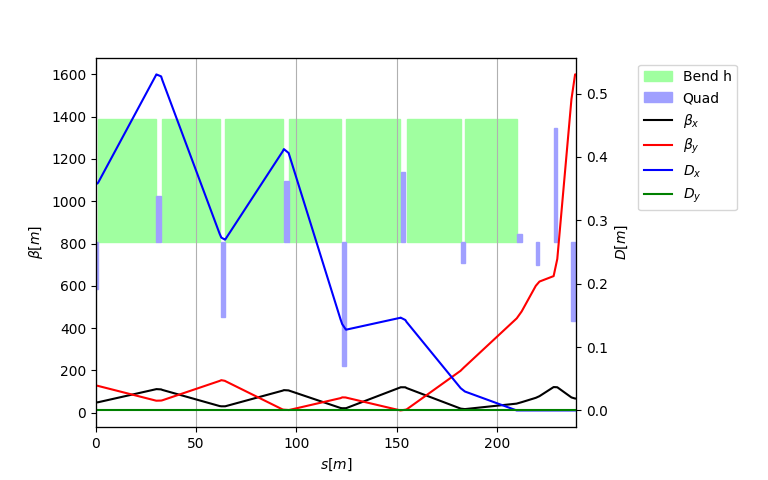

In [14]:
opt.plot()

In [15]:
# Other side from the ip is symmetric
kq_right = ['kqfm0r', 'kqdm0r', 'kqfm1r', 'kqdm2r', 'kqfm3r',
            'kqdm4r', 'kqfm5r', 'kqdm6r', 'kqfm7r', 'kqdm8r']

env['kqfm0r'] = 'kqfm0l'
env['kqdm0r'] = 'kqdm0l'
env['kqfm1r'] = 'kqfm1l'
env['kqdm2r'] = 'kqdm2l'
env['kqfm3r'] = 'kqfm3l'
env['kqdm4r'] = 'kqdm4l'
env['kqfm5r'] = 'kqfm5l'
env['kqdm6r'] = 'kqdm6l'
env['kqfm7r'] = 'kqfm7l'
env['kqdm8r'] = 'kqdm8l'

In [17]:
strengths = line.vars.get_table().rows[kq_ff_ds + kq_right]
strengths = strengths.to_dict()

In [18]:
xt.json.dump(strengths, 'strengths_quads_05_ffds_lr.json')

In [19]:
!cat strengths_quads_05_ffds_lr.json

{
 "kqfm0l": 0.01331507682069418,
 "kqdm0l": -0.021466391080068686,
 "kqfm1l": 0.017586603876134213,
 "kqdm2l": -0.03540401601021949,
 "kqfm3l": 0.02020348230309806,
 "kqdm4l": -0.00581183113473421,
 "kqfm5l": 0.0023653035948979833,
 "kqdm6l": -0.0065914190001548955,
 "kqfm7l": 0.03286042425702848,
 "kqdm8l": -0.022602107754993547,
 "kqfm0r": "kqfm0l",
 "kqdm0r": "kqdm0l",
 "kqfm1r": "kqfm1l",
 "kqdm2r": "kqdm2l",
 "kqfm3r": "kqfm3l",
 "kqdm4r": "kqdm4l",
 "kqfm5r": "kqfm5l",
 "kqdm6r": "kqdm6l",
 "kqfm7r": "kqfm7l",
 "kqdm8r": "kqdm8l"
}